In [1]:
#import dependencies

import urllib
import io
import numpy as np
from PIL import Image
from typing import Tuple
from sklearn.decomposition import PCA
from scipy.ndimage import binary_closing, binary_opening
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
from sklearn.neighbors import NearestNeighbors
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.colors as pltColor
from matplotlib.patches import ConnectionPatch
import numpy as np
from PIL import Image
import os
import sys
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import cuvis

In [2]:
# set image files and default values


os.environ["XFORMERS_DISABLED"] = "1" # Switch to enable xFormers

REPO_NAME = "facebookresearch/dinov2"
MODEL_NAME = "dinov2_vitb14_reg"

# hyperspectral_image1 = '../../HyperImages/img1.tiff'
# hyperspectral_image2 =  '../../HyperImages/img1.tiff'
STANDARD_ARRAY_URL = "https://dl.fbaipublicfiles.com/dinov2/arrays/standard.npy"

DEFAULT_SMALLER_EDGE_SIZE = 448
DEFAULT_BACKGROUND_THRESHOLD = 0.05
DEFAULT_APPLY_OPENING = False
DEFAULT_APPLY_CLOSING = False

# autoencoder_file = "/workspaces/HyperTools/spectral_model.pth"

test_index=0 # shows reconstruction of test index on image 1 for the autoencoder 
back_treshold_temp_rgb = .05
back_treshold_temp_spectral = .05

#cuvis stuff 



userSettingsDir = "../settings/ultris20/" 
darkLoc = "../../HyperImages/cornfields/Calibration/dark__session_002_003_snapshot16423119279414228.cu3"
whiteLoc = "../../HyperImages/cornfields/Calibration/white__session_002_752_snapshot16423136896447489.cu3"
distanceLoc = "../../HyperImages/cornfields/Calibration/distanceCalib__session_000_790_snapshot16423004058237746.cu3"
factoryDir = "../settings/ultris20/" # init.daq file
outDir ="../../HyperImages/export/"

hyperspectral_image1 =  "../../HyperImages/cornfields/session_002/session_002_490.cu3"
hyperspectral_image2 =   "../../HyperImages/cornfields/session_002/session_002_491.cu3"

# hyperspectral_image1 =  "../../HyperImages/candlefog-1/session_000_004.cu3"
# hyperspectral_image2 =   "../../HyperImages/candlefog-1/session_000_031.cu3"

# hyperspectral_image1 =  "../../HyperImages/wextel-1/session_000_182.cu3"
# hyperspectral_image2 =   "../../HyperImages/wextel-1/session_000_184.cu3"


# hyperspectral_image1 =  "../../HyperImages/cornflakes_and_pasta/cornflakes_and_noodles_000/cornflakes_and_noodles_000_000_snapshot.cu3"
# hyperspectral_image2 =   "../../HyperImages/cornflakes_and_pasta/cornflakes_and_noodles_000/cornflakes_and_noodles_000_001_snapshot.cu3"

# hyperspectral_image1 =  "../../HyperImages/lentils/lentils/anuga_alle_linsen_000_000_snapshot.cu3"
# hyperspectral_image2 =   "../../HyperImages/lentils/lentils/anuga_alle_linsen_000_001_snapshot.cu3"


# userSettingsDir = "../settings/ultris5/" 


# darkLoc = "../../HyperImages/cornflakes_and_pasta/Calibration/dark__white_t0_000_003_snapshot16608092528114334.cu3"
# whiteLoc = "../../HyperImages/cornflakes_and_pasta/Calibration/white__white_t0_000_001_snapshot16608092319762515.cu3"
# distanceLoc = "../../HyperImages/cornflakes_and_pasta/Calibration/distanceCalib__white_1100_000_002_snapshot16608134864104242.cu3"
# factoryDir = "../settings/ultris5/" # init.daq file
# outDir ="../../HyperImages/export/"


default_width = 448
default_height = 448


In [3]:

# intialize functions




def load_array_from_url(url: str) -> np.ndarray:
    with urllib.request.urlopen(url) as f:
        array_data = f.read()
        g = io.BytesIO(array_data)
        return np.load(g)


# def load_image_from_url(url: str) -> Image:
#     # with urllib.request.urlopen(url) as f:
#     #     return Image.open(f).convert("RGB")
#     return Image.open(url).convert("RGB")


def make_transform(smaller_edge_size: int) -> transforms.Compose:
    IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
    IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
    interpolation_mode = transforms.InterpolationMode.BICUBIC

    return transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=interpolation_mode, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ])


def prepare_image(image: Image,
                  smaller_edge_size: float,
                  patch_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    transform = make_transform(int(smaller_edge_size))
    print(image.size)
    image_tensor = transform(image)

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % patch_size, height - height % patch_size
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // patch_size, cropped_width // patch_size) # h x w (TODO: check)
    return image_tensor, grid_size


def make_foreground_mask(tokens,
                         grid_size: Tuple[int, int],
                         background_threshold: float = 0.0,
                         apply_opening: bool = True,
                         apply_closing: bool = True):
    projection = tokens @ standard_array
    mask = projection > background_threshold
    mask = mask.reshape(*grid_size)
    if apply_opening:
        mask = binary_opening(mask)
    if apply_closing:
        mask = binary_closing(mask)
    return mask.flatten()



# def render_patch_pca(image: Image,
#                      smaller_edge_size: float = 448,
#                      patch_size: int = 14,
#                      background_threshold: float = 0.05,
#                      apply_opening: bool = False,
#                      apply_closing: bool = False) -> Image:
#     image_tensor, grid_size = prepare_image(image, smaller_edge_size, patch_size)

#     with torch.inference_mode():
#         image_batch = image_tensor.unsqueeze(0)
#         tokens = model.get_intermediate_layers(image_batch)[0].squeeze()

#     mask = make_foreground_mask(tokens,
#                                 grid_size,
#                                 background_threshold,
#                                 apply_opening,
#                                 apply_closing)

#     pca = PCA(n_components=3)
#     pca.fit(tokens[mask])
#     projected_tokens = pca.transform(tokens)

#     t = torch.tensor(projected_tokens)
#     t_min = t.min(dim=0, keepdim=True).values
#     t_max = t.max(dim=0, keepdim=True).values
#     normalized_t = (t - t_min) / (t_max - t_min)

#     array = (normalized_t * 255).byte().numpy()
#     array[~mask] = 0
#     array = array.reshape(*grid_size, 3)

#     return Image.fromarray(array).resize((image.width, image.height), 0)


def load_hsi(file_name):
    # load hyperspectral image
    _, extension = os.path.splitext(file_name)

    if extension == '.tiff':
        #below is a way to load hyperspectral images that are tiff files
        mylist = []
        loaded,mylist = cv2.imreadmulti(mats = mylist, filename = file_name, flags = cv2.IMREAD_ANYCOLOR )
        cube=np.array(mylist)
        cube = cube[:, :, :]
    else :
        print("Error: file type not supported")
        return
    return cube



class Dinov2Matcher:

  def __init__(self, repo_name="facebookresearch/dinov2", model_name="dinov2_vitb14_reg", smaller_edge_size=448, half_precision=False, device="cuda"):
    self.repo_name = repo_name
    self.model_name = model_name
    self.smaller_edge_size = smaller_edge_size
    self.half_precision = half_precision
    self.device = device

    if self.half_precision:
      self.model = torch.hub.load(repo_or_dir=repo_name, model=model_name).half().to(self.device)
    else:
      self.model = torch.hub.load(repo_or_dir=repo_name, model=model_name).to(self.device)

    self.model.eval()

    self.transform = transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet defaults
      ])

  # https://github.com/facebookresearch/dinov2/blob/255861375864acdd830f99fdae3d9db65623dafe/notebooks/features.ipynb
  def prepare_image(self, rgb_image_numpy):
    # image = Image.fromarray(rgb_image_numpy)

    if isinstance(rgb_image_numpy, np.ndarray):
        image = Image.fromarray(rgb_image_numpy)
    elif isinstance(rgb_image_numpy, Image.Image):
        image = rgb_image_numpy
    else:
        raise TypeError('rgb_image_numpy must be a NumPy array or a PIL Image')

    image_tensor = self.transform(image)
    resize_scale = image.width / image_tensor.shape[2]

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % self.model.patch_size, height - height % self.model.patch_size # crop a bit from right and bottom parts
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // self.model.patch_size, cropped_width // self.model.patch_size)
    return image_tensor, grid_size, resize_scale

  def prepare_mask(self, mask_image_numpy, grid_size, resize_scale):
    cropped_mask_image_numpy = mask_image_numpy[:int(grid_size[0]*self.model.patch_size*resize_scale), :int(grid_size[1]*self.model.patch_size*resize_scale)]
    image = Image.fromarray(cropped_mask_image_numpy)
    resized_mask = image.resize((grid_size[1], grid_size[0]), resample=Image.Resampling.NEAREST)
    resized_mask = np.asarray(resized_mask).flatten()
    return resized_mask

  def extract_features(self, image_tensor):
    with torch.inference_mode():
      if self.half_precision:
        image_batch = image_tensor.unsqueeze(0).half().to(self.device)
      else:
        image_batch = image_tensor.unsqueeze(0).to(self.device)

      tokens = self.model.get_intermediate_layers(image_batch)[0].squeeze()
    return tokens.cpu().numpy()

  def idx_to_source_position(self, idx, grid_size, resize_scale):
    row = (idx // grid_size[1])*self.model.patch_size*resize_scale + self.model.patch_size / 2
    col = (idx % grid_size[1])*self.model.patch_size*resize_scale + self.model.patch_size / 2
    return row, col

  def get_embedding_visualization(self, tokens, grid_size, resized_mask=None):
    pca = PCA(n_components=3)
    if resized_mask is not None:
      tokens = tokens[resized_mask]
    reduced_tokens = pca.fit_transform(tokens.astype(np.float32))
    if resized_mask is not None:
      tmp_tokens = np.zeros((*resized_mask.shape, 3), dtype=reduced_tokens.dtype)
      tmp_tokens[resized_mask] = reduced_tokens
      reduced_tokens = tmp_tokens
    reduced_tokens = reduced_tokens.reshape((*grid_size, -1))
    normalized_tokens = (reduced_tokens-np.min(reduced_tokens))/(np.max(reduced_tokens)-np.min(reduced_tokens))
    return normalized_tokens
  
  def get_embedding_visualization_manifold(self, tokens, grid_size, resized_mask=None, random_state=20):
      tsne = TSNE(n_components=3, random_state=random_state)
      if resized_mask is not None:
          tokens = tokens[resized_mask]
      reduced_tokens = tsne.fit_transform(tokens.astype(np.float32))
      if resized_mask is not None:
          tmp_tokens = np.zeros((*resized_mask.shape, 3), dtype=reduced_tokens.dtype)
          tmp_tokens[resized_mask] = reduced_tokens
          reduced_tokens = tmp_tokens
      reduced_tokens = reduced_tokens.reshape((*grid_size, -1))
      normalized_tokens = (reduced_tokens-np.min(reduced_tokens))/(np.max(reduced_tokens)-np.min(reduced_tokens))
      return normalized_tokens


def extract_rgb(cube, red_layer=78 , green_layer=40, blue_layer=25,  visualize=False):


    red_img = cube[ red_layer,:,:]
    green_img = cube[ green_layer,:,:]
    blue_img = cube[ blue_layer,:,:]


    data=np.stack([red_img,green_img,blue_img], axis=-1)
    # print(data.shape)
    #print(type(image))

    #convert to 8bit
    x_norm = (data-np.min(data))/(np.max(data)-np.min(data))
    image=(x_norm*255).astype('uint8')
    if visualize:
        #pass
        plt.imshow(image)
        plt.show()
    return image
def render_patch_tsne(image: Image,
                      smaller_edge_size: float = 448,
                      patch_size: int = 14,
                      background_threshold: float = 0.05,
                      apply_opening: bool = False,
                      apply_closing: bool = False) -> Image:
    image_tensor, grid_size = prepare_image(image, smaller_edge_size, patch_size)

    with torch.inference_mode():
        image_batch = image_tensor.unsqueeze(0)
        tokens = model.get_intermediate_layers(image_batch)[0].squeeze()

    mask = make_foreground_mask(tokens,
                                grid_size,
                                background_threshold,
                                apply_opening,
                                apply_closing)

    tsne = TSNE(n_components=3)
    projected_tokens = tsne.fit_transform(tokens[mask])

    t = torch.tensor(projected_tokens)
    t_min = t.min(dim=0, keepdim=True).values
    t_max = t.max(dim=0, keepdim=True).values
    normalized_t = (t - t_min) / (t_max - t_min)

    array = np.zeros((*grid_size, 3), dtype=np.uint8)
    reshaped_mask = mask.reshape(*grid_size)
    array[reshaped_mask] = (normalized_t * 255).byte().numpy()

    return Image.fromarray(array).resize((image.width, image.height), 0)
  
  





In [4]:
#cuvis functions 

def   reprocessMeasurement(userSettingsDir,measurementLoc,darkLoc,whiteLoc,distanceLoc,factoryDir):    
    
    # print("loading user settings...")
    settings = cuvis.General(userSettingsDir)
    # settings.setLogLevel("info")

    # print("loading measurement file...")
    mesu = cuvis.Measurement(measurementLoc)
    
    
    #  // Get the GPS data
    # const cuvis::Measurement::gps_data_t* gps_data = measurement.get_gps();

    # // Iterate over the GPS data and print the coordinates
    # for (const auto& pair : *gps_data) {
    #     std::cout << "Key: " << pair.first << ", Latitude: " << pair.second.latitude << ", Longitude: " << pair.second.longitude << std::endl;
    # }
    
    # # Get the GPS data
    # gps_data = mesu.get_gps()

    # # Iterate over the GPS data and print the coordinates
    # for key, gps in gps_data.items():
    #     print(f"Key: {key}, Latitude: {gps.latitude}, Longitude: {gps.longitude}")
        

    # print("loading dark...")
    dark = cuvis.Measurement(darkLoc)
    # print("loading white...")
    white = cuvis.Measurement(whiteLoc)
    # print("loading dark...")
    distance = cuvis.Measurement(distanceLoc)

    # print("Data 1 {} t={}ms mode={}".format(mesu.Name,mesu.IntegrationTime,mesu.ProcessingMode,))

    # print("loading calibration and processing context (factory)...")
    calibration = cuvis.Calibration(factoryDir)
    processingContext = cuvis.ProcessingContext(calibration)

    # print("set references...")
    processingContext.set_reference(dark, cuvis.ReferenceType.Dark)
    processingContext.set_reference(white, cuvis.ReferenceType.White)
    processingContext.set_reference(distance, cuvis.ReferenceType.Distance)

    modes = [
             "Reflectance"
             ]

    # procArgs = cuvis.CubertProcessingArgs()
    procArgs = cuvis.ProcessingArgs()
    # saveArgs = cuvis.SaveArgs(allow_overwrite=True)

    for mode in modes:

        procArgs.ProcessingMode = mode
        isCapable = processingContext.is_capable(mesu, procArgs)

        if isCapable:
            # print("processing to mode {}...".format(mode))
            processingContext.set_processing_args(procArgs)
            mesu = processingContext.apply(mesu)
            mesu.set_name(mode)
            # cube = mesu.Data.pop("cube", None)
            cube = mesu.data.get("cube", None)
            
            if cube is None:
                raise Exception("Cube not found")

        else:
            print("Cannot process to {} mode!".format(mode))
            
    #print("finished.")
    cube_result = cube.array
    cube_result = np.transpose(cube_result, (2, 0, 1))
    # print(cube_result.shape)
    return cube_result


def loadMeasurement(userSettingsDir, measurementLoc, visualize=False):

    print("loading user settings...")
    settings = cuvis.General(userSettingsDir)
    settings.set_log_level("info")

    print("loading measurement file...")
    mesu = cuvis.Measurement(measurementLoc)
    print("Data 1 {} t={}ms mode={}".format(mesu.name,mesu.integration_time,mesu.processing_mode.name,))

    # if not isinstance(mesu.MeasurementFlags, list):
    #     mesu.MeasurementFlags = [mesu.MeasurementFlags]

    if isinstance(mesu.measurement_flags, cuvis.MeasurementFlags):
        print(f"Flags: {mesu.measurement_flags}")
        for v in cuvis.MeasurementFlags.supremum():
            print(f'{v}: {v in mesu.measurement_flags}')
    
    cube = mesu.data.get("cube", None)
    if cube is None:
        raise Exception("Cube not found")
    
    # if len(mesu.measurement_flags) > 0:
    #     print("Flags")
    #     for flag in mesu.measurement_flags:
    #         print(" - {} ({})".format(flag, flag)) 

    # assert mesu.ProcessingMode == "Raw", \
    #     "This example requires Raw mode!"

    # cube = mesu.Data.pop("cube", None)
    cube = cube.array
    print(cube.shape)
    # cube_reshaped = cube.reshape(cube.shape[2], cube.shape[0], cube.shape[1])
    cube_result = np.transpose(cube, (2, 0, 1))
    print(cube_result.shape)
    cube = cube_result
    
    if cube is None:
        raise Exception("Cube not found")
   
    if visualize==True:
        # below is to visualize the image
        #print((cube.array.shape))
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        im = ax.imshow(cube.array[:,:, 0],cmap=plt.cm.gray, animated=True)

        def animated_image(i):
            # cube.array[x, y, chn]
            #for chn in np.arange(cube.channels):
            data = cube.array[:,:, i]
            x_norm = (data-np.min(data))/(np.max(data)-np.min(data))
            im.set_array(x_norm*50)

            plt.title("Hyperspectral Image Layer {} of {} with wavelentgth {}".format(i, mesu.Name, cube.wavelength[i]))

        print(type(cube.array[5,5, 5]))    
        ani = animation.FuncAnimation(fig, animated_image,frames=cube.channels, interval=20, repeat=False)
        plt.show()

    #print("finished.")
    return cube

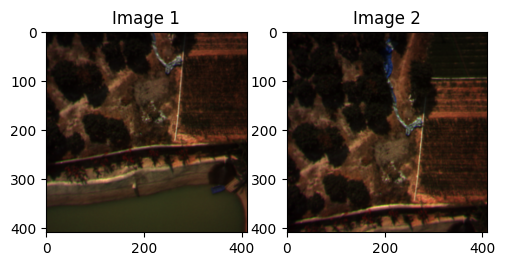

In [5]:
# load hyperspectral image and extract rgb image 

# hyperImage = load_hsi(hyperspectral_image1)  # between 0 and 255
# hyperImage2 = load_hsi(hyperspectral_image2)  #between 0 and 255

hyperImage = reprocessMeasurement(userSettingsDir,hyperspectral_image1,darkLoc,whiteLoc,distanceLoc,factoryDir)
hyperImage2 = reprocessMeasurement(userSettingsDir,hyperspectral_image2,darkLoc,whiteLoc,distanceLoc,factoryDir)

# hyperImage = loadMeasurement(userSettingsDir,hyperspectral_image1)
# hyperImage2 = loadMeasurement(userSettingsDir,hyperspectral_image2)


hyperImage_norm = (hyperImage/255).astype('float32') # between 0 and 1
hyperImage_norm2 = (hyperImage2/255).astype('float32') # between 0 and 1

num_layers = hyperImage.shape[0]

standard_array = load_array_from_url(STANDARD_ARRAY_URL)
newarr = standard_array.reshape(24, 32)
# print(newarr.shape)
# print(np.max(newarr), np.min(newarr))
# plt.subplot(1, 5, 3)
# plt.imshow(newarr)

#may need to modify to fit dinov2 model
# standard_array = (standard_array*0) + 0.43
# standard_array_doubled = np.concatenate((standard_array, standard_array), axis=0)
# standard_array = standard_array_doubled # used for some of the larger dinov2 models 
# first_half = standard_array[:len(standard_array)//2]
# standard_array = first_half

# example_image = extract_rgb(hyperImage, 31,13,2)
# example_image2 = extract_rgb(hyperImage2,31,13,2)
example_image = extract_rgb(hyperImage)
example_image2 = extract_rgb(hyperImage2)


fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 5, 1)  # 1 row, 3 columns, 1st subplot = image1
plt.imshow(example_image)
plt.title('Image 1')

plt.subplot(1, 5, 2)  # 1 row, 3 columns, 1st subplot = image1
plt.imshow(example_image2)
plt.title('Image 2')

plt.show()


In [13]:
def dense_match_hsb(features1, features2):
  similarity = cosine_similarity(features1, features2)
  similarity = np.clip(similarity, 0, 1)
  similarity = np.round(similarity, decimals =5)
  # print("similarity matrix",similarity)
  #go through each row of data and get the maximum value, which is equal to our value number in hsb
  #need to save index here of match
  # need to take similarity matrix, find max in each column, find index of that max, and create array of these maxes
  # def find_max_index(col):
  #   pass
  # similarity_indexes = np.apply_along_axis(find_max_index, axis=1, arr=similarity)

  hsb_values_temp = similarity.max(axis=1)
  hsb_values = np.zeros(features1.shape[0]+features2.shape[0], dtype = float)
  column_indices = column_indices = np.argmax(similarity, axis=1) #np.where(similarity == hsb_values_temp)
  # print("hsb_values_temp", hsb_values_temp)
  # print("column_indices: ", column_indices)
  # print("value shape", hsb_values.shape)
  # print(hsb_values)
  
  #saturation all ones right now for just rgb
  hsb_saturation = np.ones(features1.shape[0]+features2.shape[0], dtype = float)
  # print("saturation shape", hsb_saturation.shape)
  
  
  combinefeatures = np.concatenate((features1, features2), axis=0)
  # print("combined features shape ", combinefeatures.shape)
  combinefeats_avg = np.mean(combinefeatures, axis=0)
  # print("avg vector shape " ,combinefeats_avg.shape)


  def func(x):
    #angle_rad = np.arctan2(np.linalg.norm(np.cross(x, combinefeats_avg), np.dot(x, combinefeats_avg)))
    angle_rad = np.arccos(np.dot(x, combinefeats_avg)/(np.linalg.norm(x)*np.linalg.norm(combinefeats_avg)))
    angle_deg = np.degrees(angle_rad)
    while(angle_deg < 0):
      angle_deg+=360.0
    return angle_rad+.4

  combined_hue = np.apply_along_axis(func, axis=1, arr=combinefeatures)
  # print("combined hue shape ", combined_hue.shape)
  # print(combined_hue)

  
  
  #create new array where average the matches hues together
  new_combined_hue = np.zeros(len(combined_hue), dtype = float)
  
  
  similarity_threshold = 0.85
  
  
  for i in range(int(features1.shape[0])):
    # print(combined_hue[i], combined_hue[features1.shape[0]+column_indices[0][i]])
    # print(features1.shape[0],column_indices[i])
    if hsb_values_temp[i] < similarity_threshold:
      hsb_values[i]= 0
      hsb_values[features1.shape[0]+column_indices[i]]= 0
      
      new_combined_hue[i] = 5
      new_combined_hue[features1.shape[1]+column_indices[i]] = 5
      
    else:
      tmp1 = combined_hue[i]
      tmp2 = combined_hue[features1.shape[0]+column_indices[i]]

      # take avg
      avg_val = (tmp1+tmp2)/2
      # print(features1.shape[0], 'tmp2', column_indices[0][i], 'avg', avg_val)
      new_combined_hue[i] = avg_val
      new_combined_hue[features1.shape[1]+column_indices[i]] = avg_val
      hsb_values[i]= hsb_values_temp[i]
      hsb_values[features1.shape[0]+column_indices[i]]= hsb_values_temp[i]
      # print(i,features1.shape[0]+column_indices[0][i] )

  # print("hue shape ", combined_hue.shape)
  # have hsb_values,new_combined_hue, hsb_saturation
  final = np.array([new_combined_hue*2, hsb_saturation, hsb_values])
  # print(final.shape)
  #want to return hsv 2048x3 (hue , sat, val) 2048 is number of patches
  # return np.transpose(final)
  
  tsne = PCA(n_components=3, random_state=20)
  results = tsne.fit_transform(combinefeatures)
  normalized_tokens = (results-np.min(results))/(np.max(results)-np.min(results))
  return normalized_tokens


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


(2048, 3)
[[0.19333622 0.4052363  0.28052744]
 [0.23359421 0.36266592 0.38275388]
 [0.23609442 0.32887626 0.39694324]
 ...
 [0.5136446  0.5597981  0.20331037]
 [0.45634815 0.49818906 0.26634604]
 [0.48120996 0.47798932 0.21807049]]
(1024, 768) here (1024, 768)


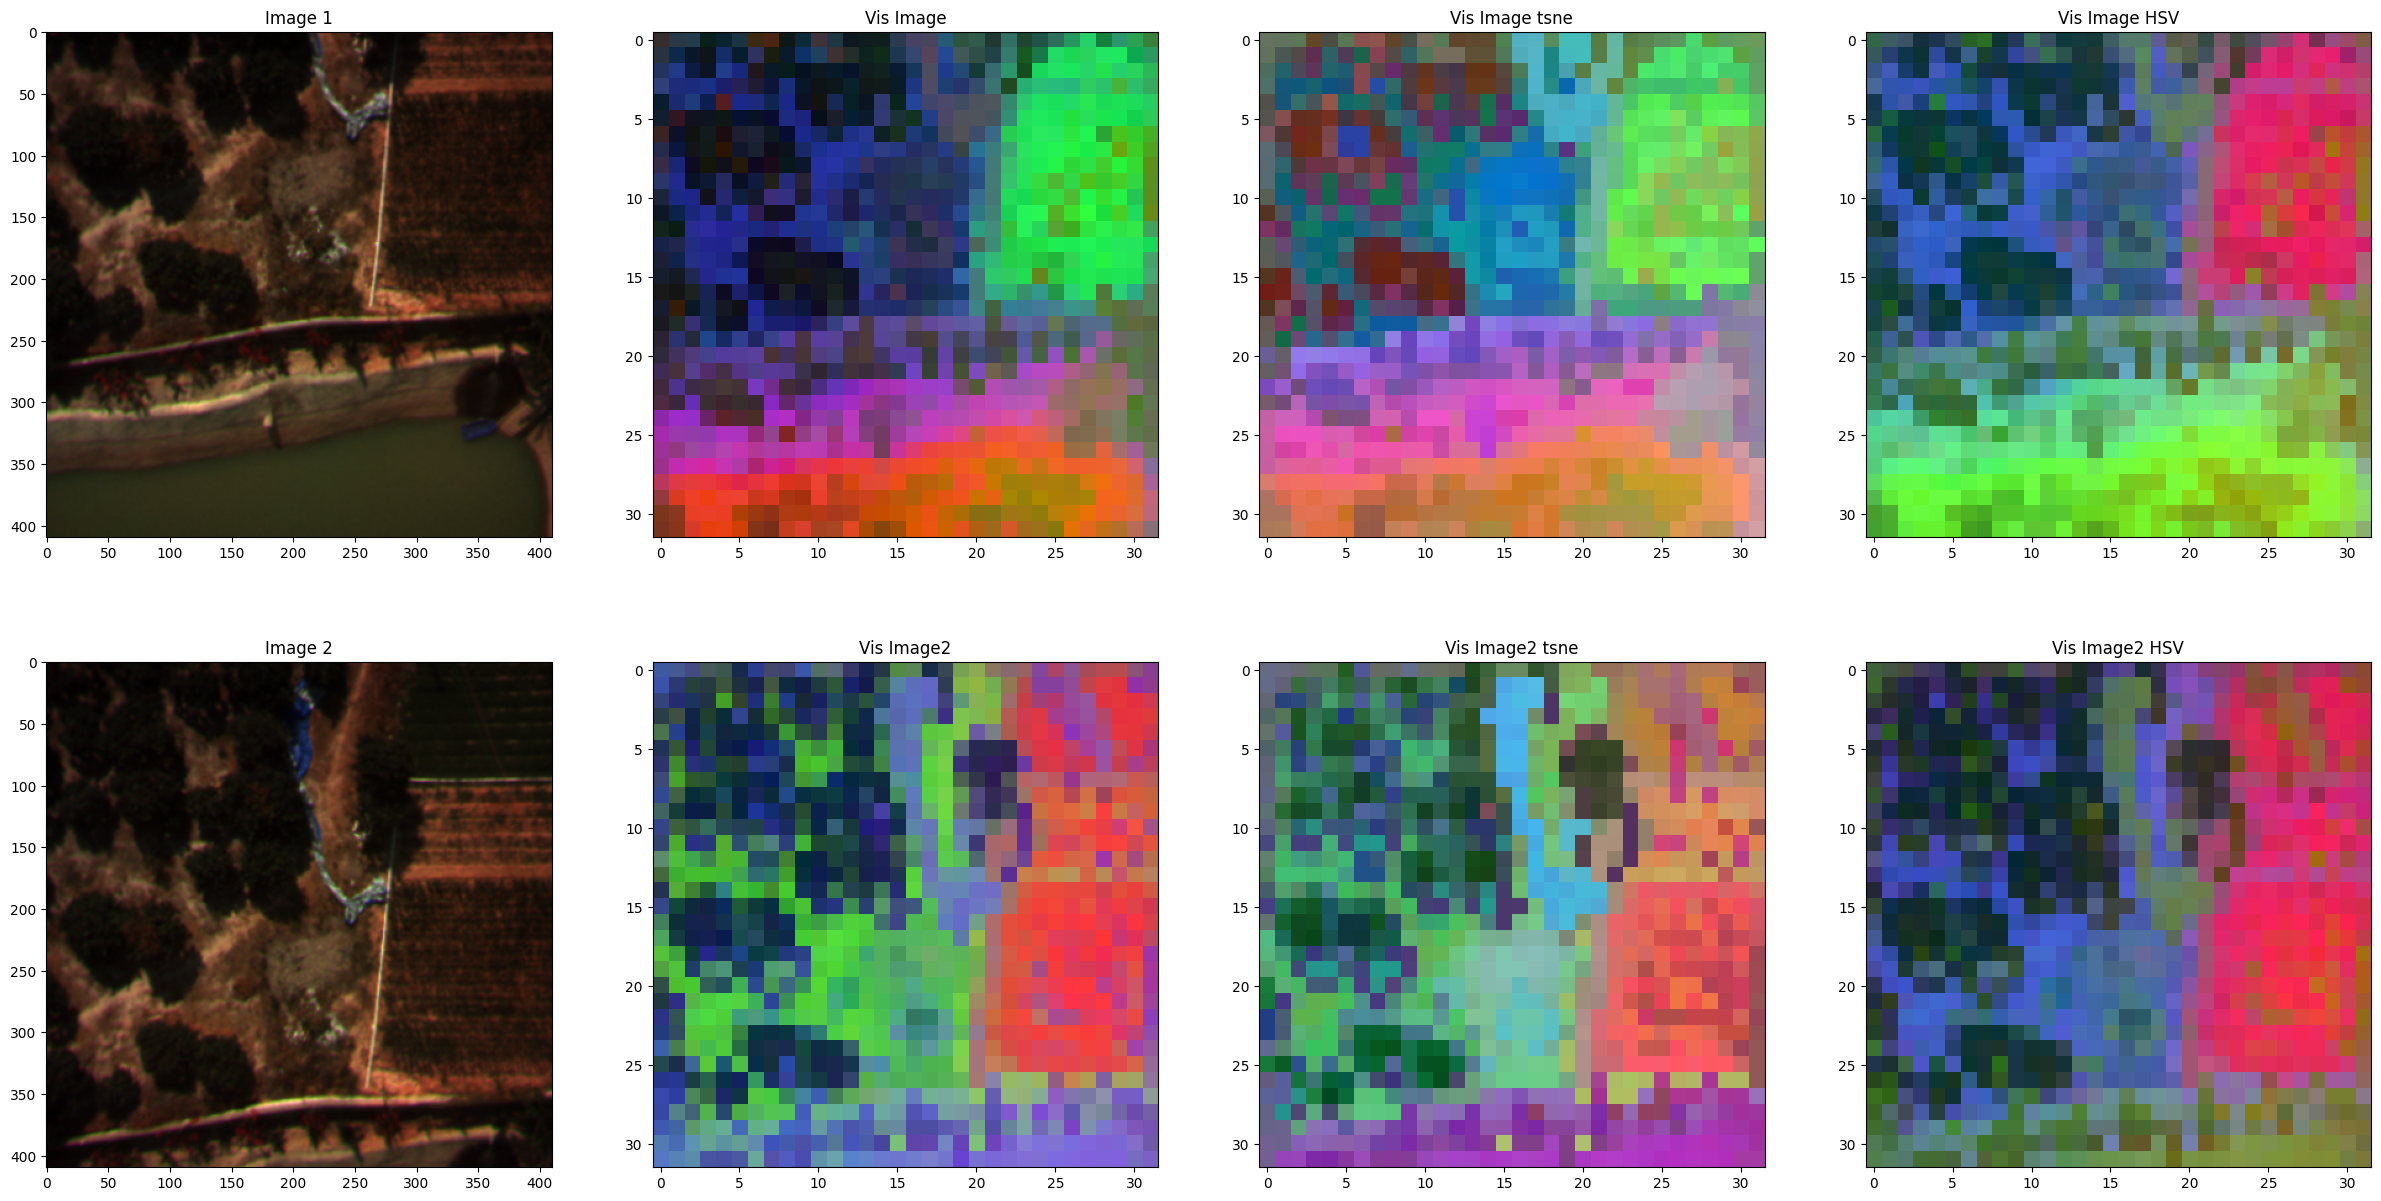

In [14]:
# create feature image from rgb images


dm = Dinov2Matcher(half_precision=False)


# Extract features
image_tensor1, grid_size1, resize_scale1 = dm.prepare_image(example_image)
features1 = dm.extract_features(image_tensor1)

# Visualization
vis_image = dm.get_embedding_visualization(features1, grid_size1)


image_tensor2, grid_size2, resize_scale2 = dm.prepare_image(example_image2)
features2 = dm.extract_features(image_tensor2)
# Visualization
vis_image2 = dm.get_embedding_visualization(features2, grid_size2)



# print(features1.shape,'here', features2.shape)
#perform dense matching
hsv_values =dense_match_hsb(features1, features2)
print(hsv_values.shape)
print(hsv_values)
rgbImg_values = hsv_values

# rgbImg_values = pltColor.hsv_to_rgb(hsv_values)
# print("rgb shape", rgbImg_values)

rgbImg_values1 = rgbImg_values[0:1024,:]
rgbImg_values2 = rgbImg_values[1024:2048,:]
reduced_tokens1 = rgbImg_values1.reshape((*grid_size1, -1))
reduced_tokens2 = rgbImg_values2.reshape((*grid_size2, -1))
vis_image_hsv=reduced_tokens1
vis_image2_hsv=reduced_tokens2

vis_image_tsne= dm.get_embedding_visualization_manifold(features1, grid_size1)
vis_image2_tsne=dm.get_embedding_visualization_manifold(features2, grid_size2)


print(features1.shape,'here', features2.shape)

fig = plt.figure(figsize=(30, 15))

plt.subplot(2, 4, 1)  # 2 rows, 4 columns, 1st subplot = image1
plt.imshow(example_image)
plt.title('Image 1')

plt.subplot(2, 4, 2)  # 2 rows, 4 columns, 2nd subplot = vis_image
plt.imshow(vis_image)
plt.title('Vis Image')

plt.subplot(2, 4, 3)  # 2 rows, 4 columns, 3rd subplot = vis_image
plt.imshow(vis_image_tsne)
plt.title('Vis Image tsne')

plt.subplot(2, 4, 4)  # 2 rows, 4 columns, 3rd subplot = vis_image
plt.imshow(vis_image_hsv)
plt.title('Vis Image HSV')

plt.subplot(2, 4, 5)  # 2 rows, 4 columns, 5th subplot = image2
plt.imshow(example_image2)
plt.title('Image 2')

plt.subplot(2, 4, 6)  # 2 rows, 4 columns, 6th subplot = vis_image2
plt.imshow(vis_image2)
plt.title('Vis Image2')

plt.subplot(2, 4, 7)  # 2 rows, 4 columns, 7th subplot = vis_image2 tsne
plt.imshow(vis_image2_tsne)
plt.title('Vis Image2 tsne')

plt.subplot(2, 4, 8)  # 2 rows, 4 columns, 3rd subplot = vis_image
plt.imshow(vis_image2_hsv)
plt.title('Vis Image2 HSV')

plt.show()


